## Baseline Scenario

#### Fixed Split:

- Bandwidth: 75% to user equipment, 25% to sensors
- Computational power: 75% to user equipment, 25% to sensors

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

# predefined smart city scenario
from mobile_env.scenarios.smart_city import MComSmartCity

In [2]:
import numpy as np

# overall number of active connections for UEs
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])

# overall number of active connections for sensors
def overall_connections_sensor(sim):
    return sum(len(conns) for conns in sim.connections_sensor.values())


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}

# monitors utility per sensor
def user_utility_sensor(sim):
    return {sensor.sensor_id: utility for sensor, utility in sim.utilities_sensor.items()}


# monitors each user equipment's distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestation
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector


    distances = {}    
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2))
        
        distances[ue_id] = dist
    
    return distances

# monitors each sensor's distance to their closest base station
def sensor_closest_distance(sim):
    # position vector of basestations
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector

    distances = {}    
    for sensor_id, sensor in sim.sensors.items():
        spos = np.array([[sensor.x, sensor.y]])
        dist = np.sqrt(np.sum((bpos - spos)**2))
        
        distances[sensor_id] = dist
    
    return distances


# number of UE connections per basestation
def station_connections_ue(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}

# number of sensor connections per basestation
def station_connections_sensor(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections_sensor.items()}

In [3]:
# add throughput metrics

def calculate_total_data_rate_bs(sim):
    """Calculate total data rate for all base stations in the environment."""
    data_rate_bs = {}

    for bs in sim.stations.values():
        # Sum data rates for all UEs connected to the base station
        ue_data_rate = sum(sim.datarates[(bs, ue)] for ue in sim.connections[bs])

        # Sum data rates for all sensors connected to the base station
        sensor_data_rate = sum(sim.datarates_sensor[(bs, sensor)] for sensor in sim.connections_sensor[bs])

        # Total data rate for the base station
        total_data_rate = ue_data_rate + sensor_data_rate

        # Store the data rate value for this base station
        data_rate_bs[bs.bs_id] = total_data_rate

    return data_rate_bs

def calculate_total_data_rate_ue(sim):
    """Calculate the total data rate for UEs in the environment."""
    
    # Initialize dictionary to store data rate for each UE
    data_rate_ue = {}

    # Calculate datarate for UEs
    for ue in sim.users.values():
        # Get the total data rate for this UE
        total_data_rate_ue = sum(sim.datarates[(bs, ue)] for bs in sim.stations.values() if (bs, ue) in sim.datarates)
        
        # Assume time window of 1 second for data rate calculation
        data_rate_ue[ue.ue_id] = total_data_rate_ue * 1

    return data_rate_ue


def calculate_total_data_rate_sensor(sim):
    """Calculate the data rate for sensors in the environment."""
    
    # Initialize dictionaries to store data rate for each sensor
    sensor_data_rate = {}

    # Calculate datarate for sensors
    for sensor in sim.sensors.values():
        # Get the total data rate for this sensor
        total_data_rate_sensor = sum(sim.datarates_sensor[(bs, sensor)] for bs in sim.stations.values() if (bs, sensor) in sim.datarates_sensor)
        
        # Assume time window of 1 second for data rate calculation
        sensor_data_rate[sensor.sensor_id] = total_data_rate_sensor * 1
        
    return sensor_data_rate

In [4]:
# add snr values as metrics

def calculate_snr_ue(sim):
    """Calculate the SNR for UEs in the environment."""
    
    snr_ue = {}
    
    # Loop over all UEs to calculate SNR
    for ue in sim.users.values():
        # Find the base station connected to the UE
        for bs in sim.stations.values():
            if ue in sim.connections[bs]:
                # Use the channel object to calculate the SNR between BS and UE
                snr_value = sim.channel.snr(bs, ue)
                snr_ue[ue.ue_id] = snr_value
                break

    return snr_ue

def calculate_snr_sensor(sim):
    """Calculate the SNR for sensors in the environment."""
    
    snr_sensor = {}
    
    # Loop over all sensors to calculate SNR
    for sensor in sim.sensors.values():
        # Find the base station connected to the sensor
        for bs in sim.stations.values():
            if sensor in sim.connections_sensor[bs]:
                # Use the channel object to calculate the SNR between BS and sensor
                snr_value = sim.channel.snr(bs, sensor)
                snr_sensor[sensor.sensor_id] = snr_value
                break

    return snr_sensor

In [5]:
# Calculate bandwidth utilization and computational power utilization
    
def bandwidth_utilization_ue(sim):
    """Calculate the bandwidth utilization of ues for each base station."""
    
    bw_utilization = {}

    # Iterate over all base stations
    for bs in sim.stations.values():
        allocated_bw_ue = sim.resource_allocations[bs]['bandwidth_for_ues']
        bw_utilization[bs.bs_id] = allocated_bw_ue

    return bw_utilization

def bandwidth_utilization_sensor(sim):
    """Calculate the bandwidth utilization of sensors for each base station."""
    
    bw_utilization = {}

    # Iterate over all base stations
    for bs in sim.stations.values():
        allocated_bw_sensor = sim.resource_allocations[bs]['bandwidth_for_sensors']
        bw_utilization[bs.bs_id] = allocated_bw_sensor

    return bw_utilization


def computational_power_utilization_ue(sim):
    """Calculate the computational power utilization of ues for each base station."""
    
    cpu_utilization = {}

    for bs in sim.stations.values():
        allocated_cpu_ue = sim.resource_allocations[bs]['computational_power_for_ues']
        cpu_utilization[bs.bs_id] = allocated_cpu_ue

    return cpu_utilization

def computational_power_utilization_sensor(sim):
    """Calculate the computational power utilization of sensors for each base station."""
    
    cpu_utilization = {}

    for bs in sim.stations.values():
        allocated_cpu_sensor = sim.resource_allocations[bs]['computational_power_for_sensors']
        cpu_utilization[bs.bs_id] = allocated_cpu_sensor

    return cpu_utilization

In [6]:
# add custom metrics to config of environment
config = {"metrics": {
            "scalar_metrics": {"overall connections": overall_connections, "overall connections sensors": overall_connections_sensor},
            "ue_metrics": {"distance station": user_closest_distance, "user utility": user_utility, "user data rate": calculate_total_data_rate_ue, "user snr": calculate_snr_ue },
            "bs_metrics": {"station connections UE": station_connections_ue,"station connections sensors": station_connections_sensor, "station data rate": calculate_total_data_rate_bs, "bw utilization for users": bandwidth_utilization_ue, "bw utilization for sensors": bandwidth_utilization_sensor, "comp power utilization ue": computational_power_utilization_ue, "comp power utilization sensor": computational_power_utilization_sensor},
            "ss_metrics": {"distance station sensors": sensor_closest_distance, "sensor utility": user_utility_sensor, "sensor data rate": calculate_total_data_rate_sensor, "sensor snr": calculate_snr_sensor}
            }
         }

In [7]:
env = gym.make("mobile-smart_city-smart_city_handler-v0", config=config, render_mode="rgb_array")

print(f"\nSmart city environment with {env.NUM_USERS} users, {env.NUM_SENSORS} sensors and {env.NUM_STATIONS} cells.")


Smart city environment with 5 users, 20 sensors and 1 cells.


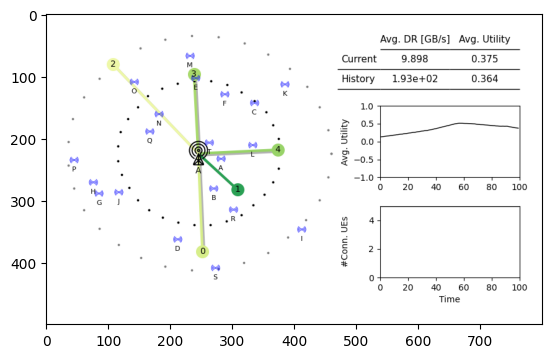

In [8]:
from IPython import display

# run the simulation for 20 time steps
done = False
obs, info = env.reset()

total_episode_reward = 0
total_reward_over_time = []  # List to store the reward at each time step

for _ in range(100):
    # here, use random dummy actions by sampling from the action space
    dummy_action = (0.75, 0.75)
    obs, reward, terminated, truncated, info = env.step(dummy_action)
    
    # accumulate total reward for the episode
    total_episode_reward += reward
    total_reward_over_time.append(total_episode_reward) 

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    
plt.close()

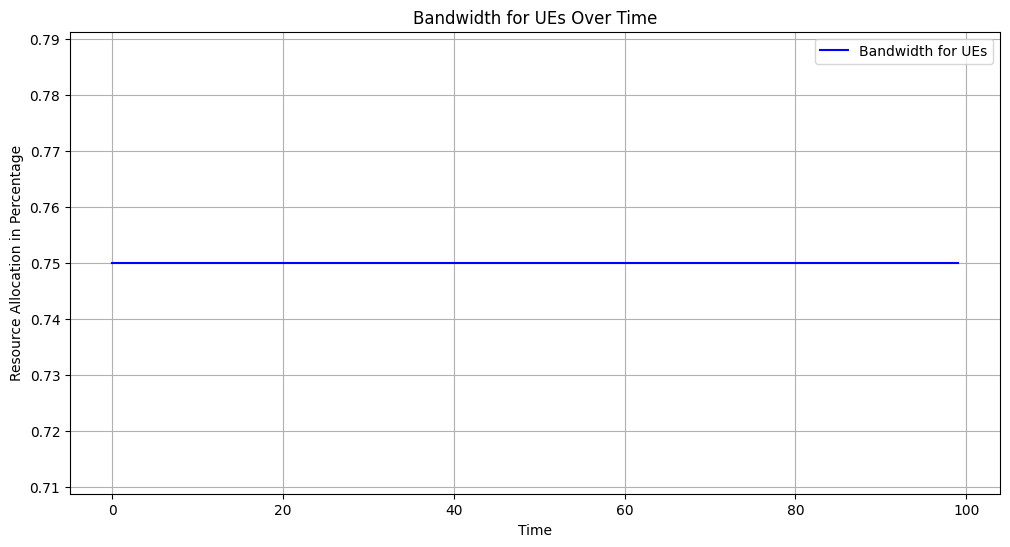

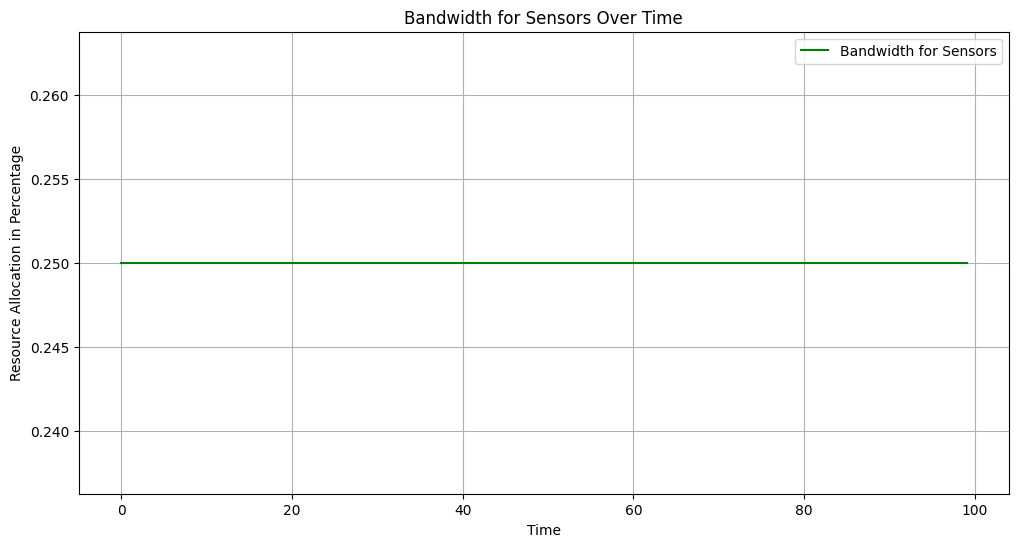

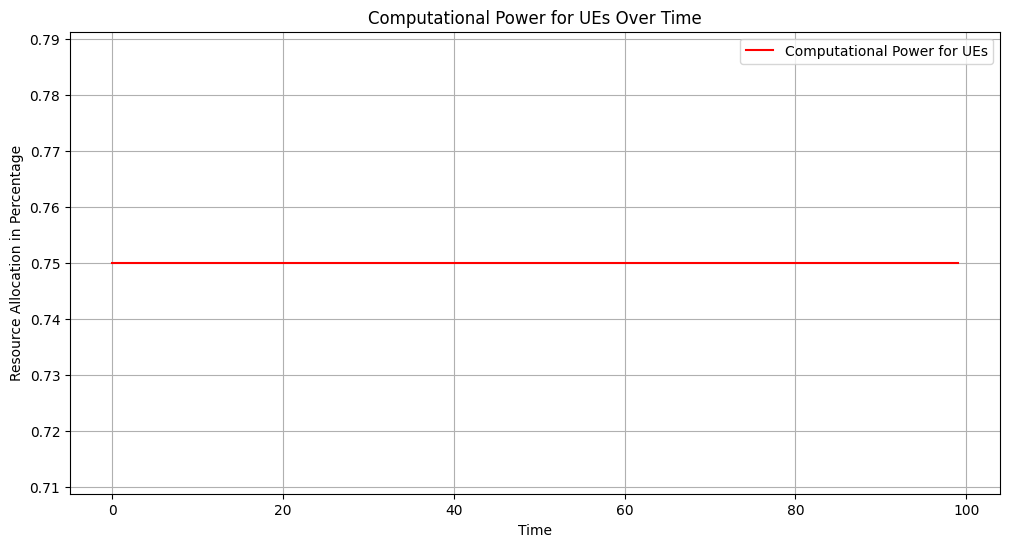

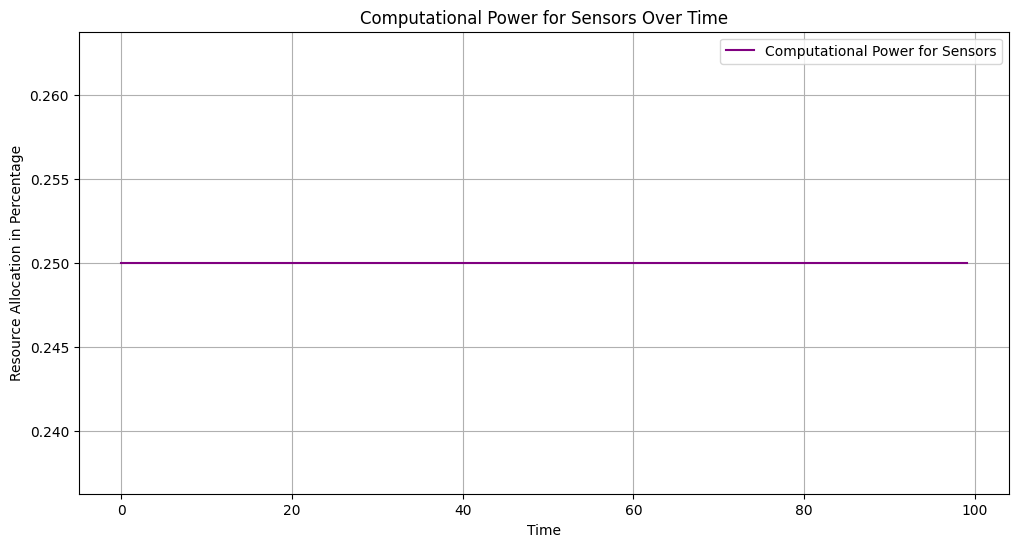

In [9]:
env.plot_resource_allocations()

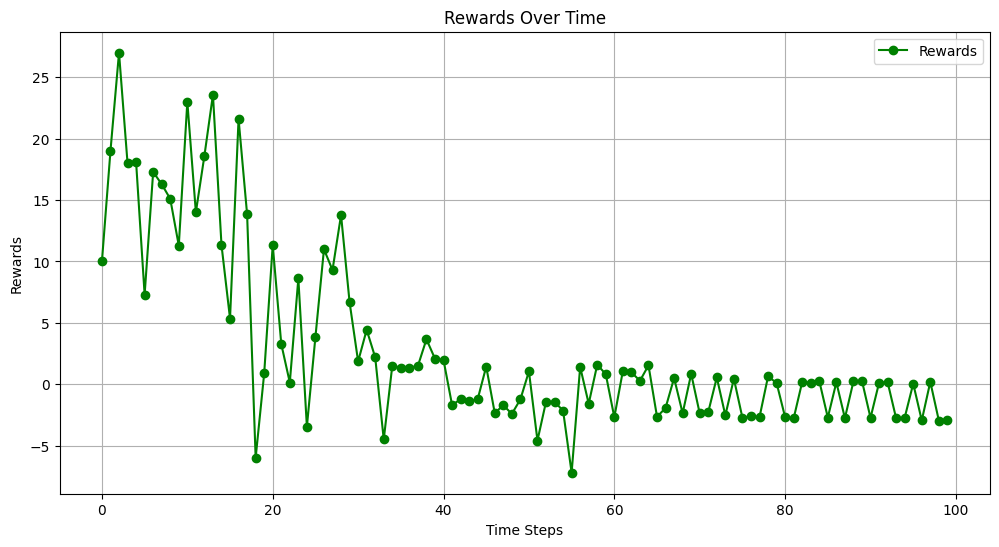

In [10]:
env.plot_rewards()

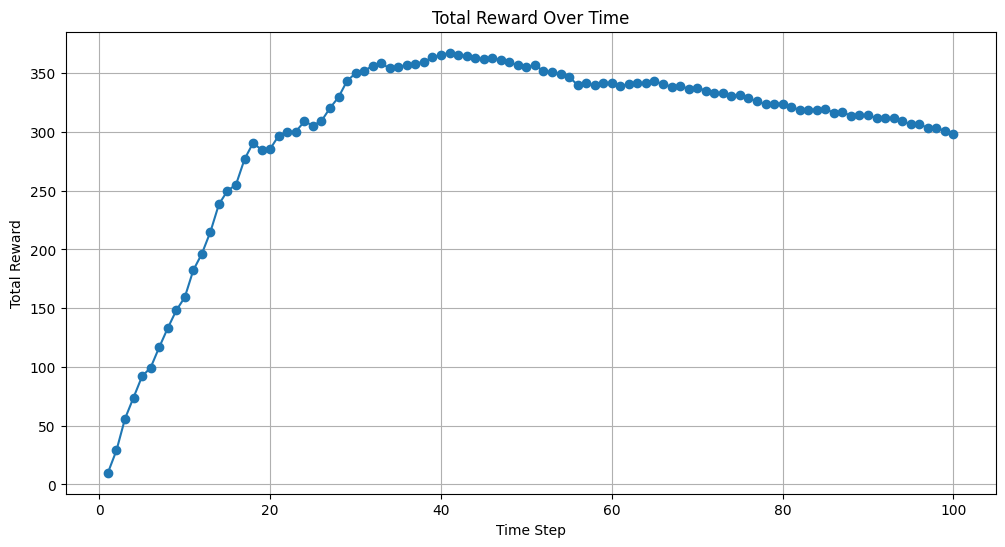

In [11]:
# Plot the reward over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(total_reward_over_time) + 1), total_reward_over_time, marker='o')
plt.title('Total Reward Over Time')
plt.xlabel('Time Step')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

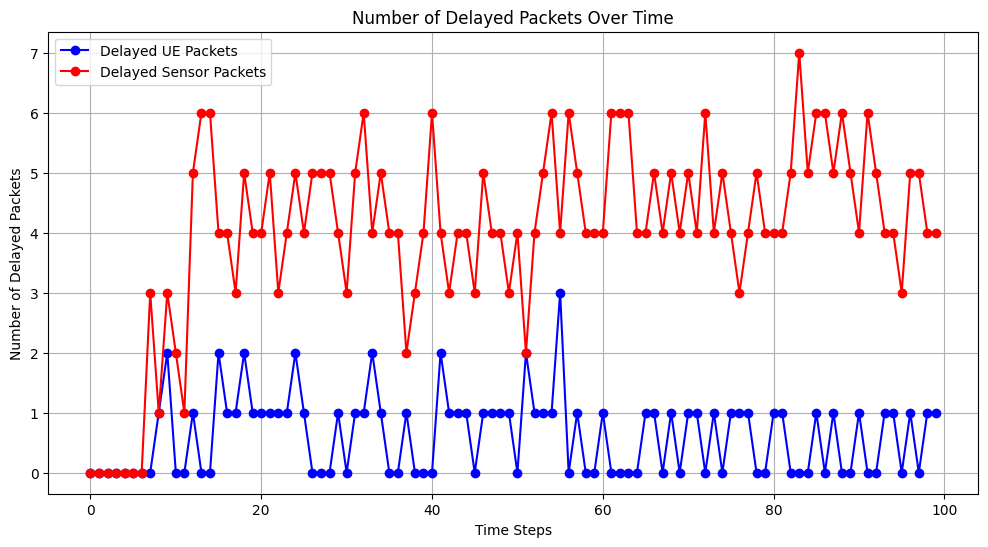

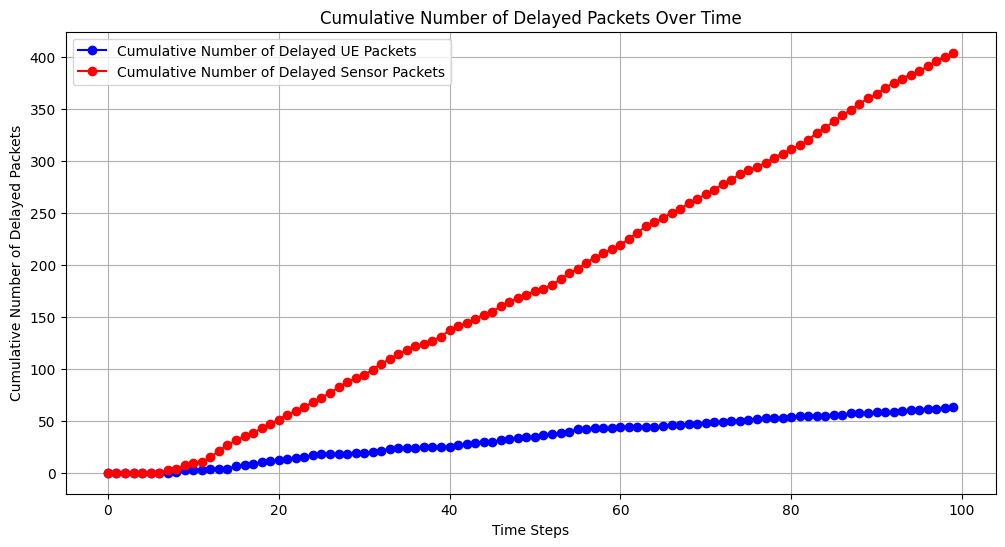

In [12]:
env.plot_delayed_packets()
env.plot_total_delayed_packets()

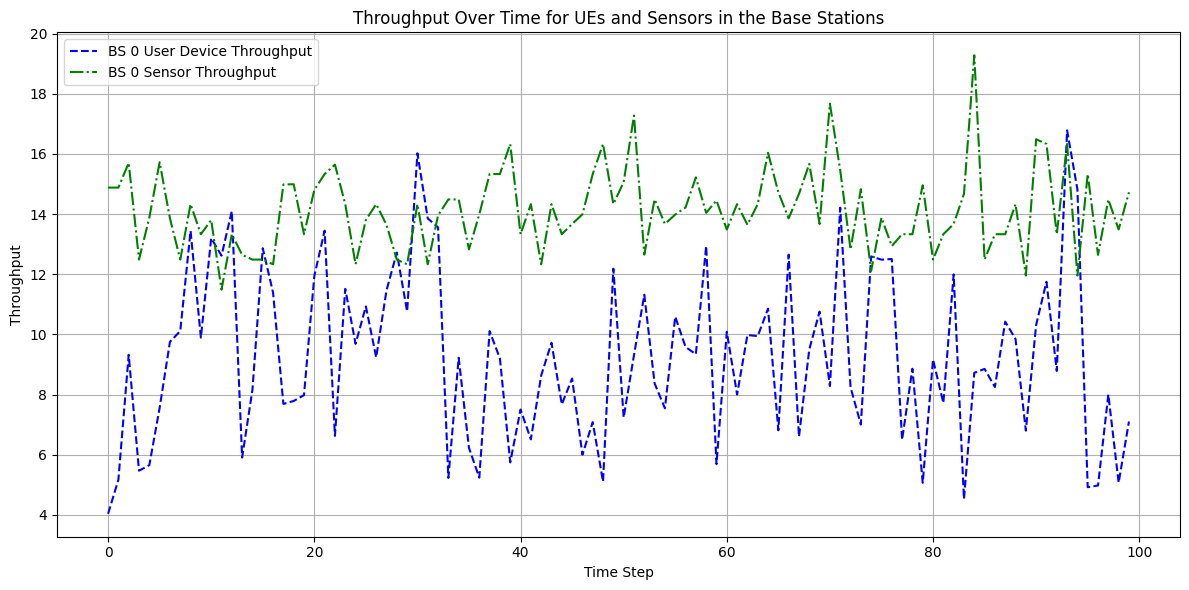

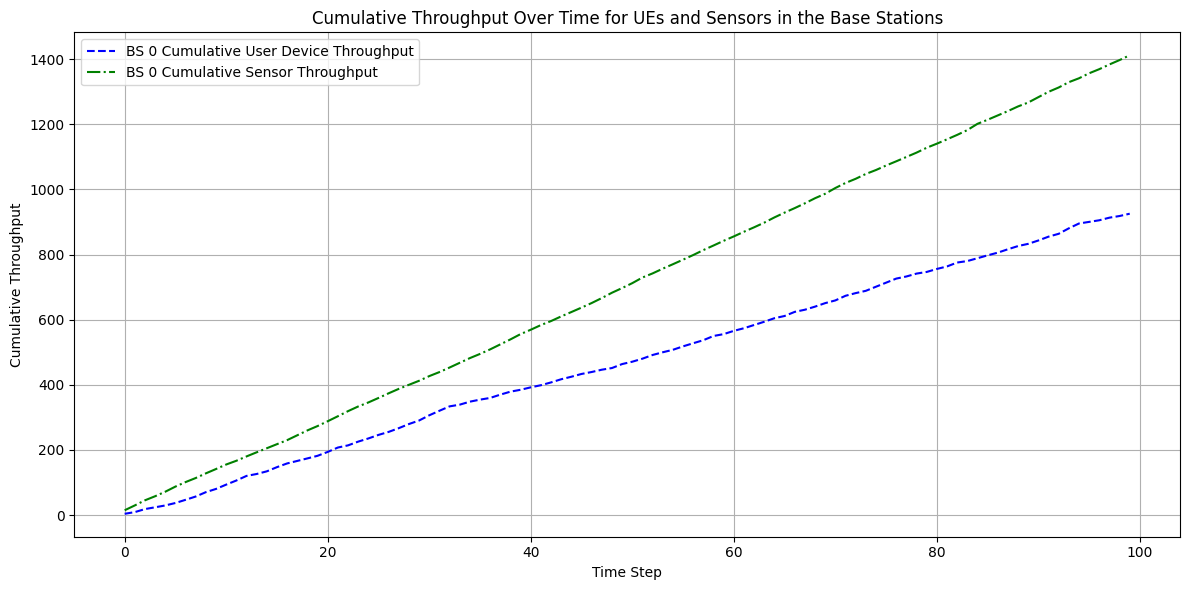

In [13]:
env.plot_throughput()
env.plot_cumulative_throughput()